In [1]:
import forecasting_system.data_access_layer as dal
import forecasting_system.data_processor as dp
import forecasting_system.data_analyser as da
import forecasting_system.modeller as m
import datetime as dt


observation_data = dal.read_data_file('demanddata_2023.csv')
observation_data = dp.format_national_grid_data(observation_data, 'ND')  # demand data is in MW

# create basic calendar variables
observation_data['Day_of_week'] = observation_data.index.to_series().dt.dayofweek
observation_data['Day_of_year'] = observation_data.index.to_series().dt.dayofyear

observation_data.head()

,SETTLEMENT_PERIOD,Observation,EMBEDDED_SOLAR_GENERATION,Day_of_week,Day_of_year
Date_Time,,,,,
2023-01-01 00:00:00,1,21043,0,6,1
2023-01-01 00:30:00,2,21756,0,6,1
2023-01-01 01:00:00,3,21348,0,6,1
2023-01-01 01:30:00,4,20586,0,6,1
2023-01-01 02:00:00,5,19781,0,6,1


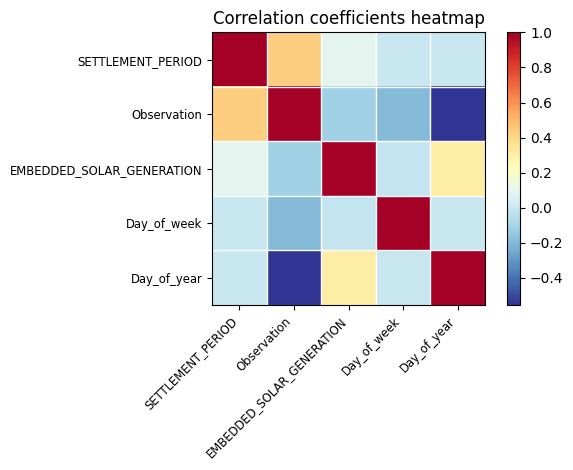

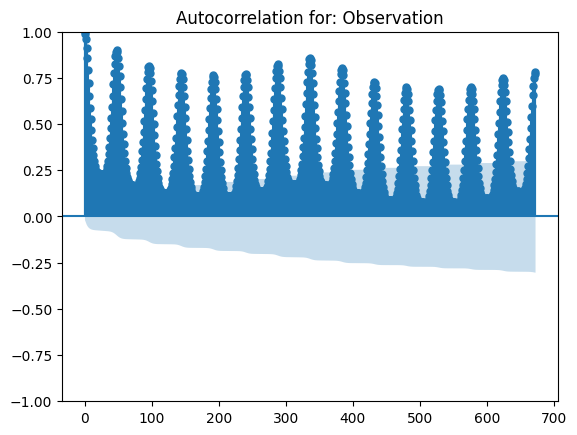

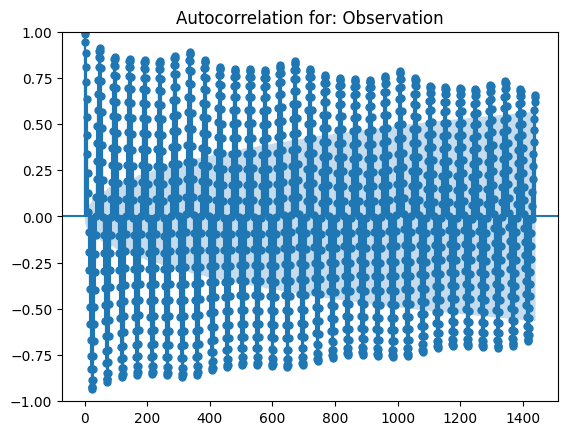

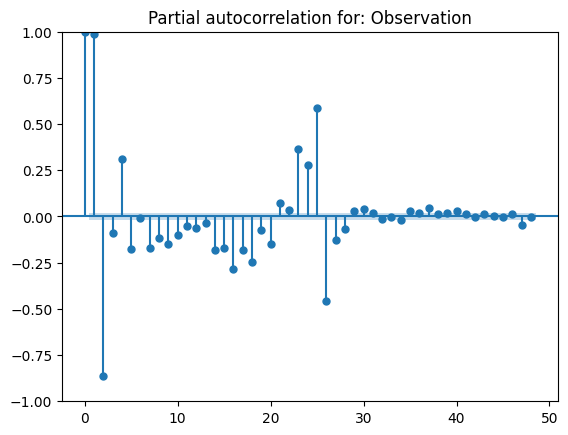

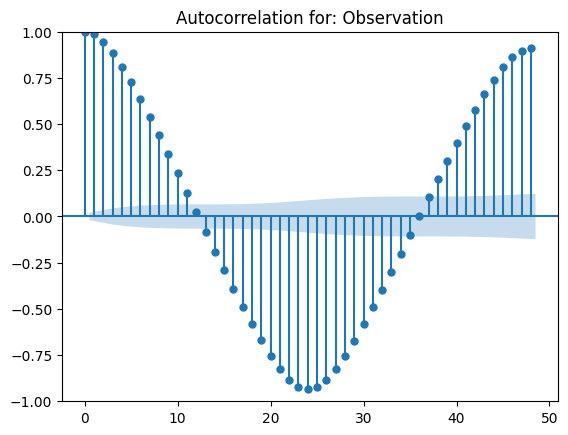

In [2]:
# Data Analysis
# determine most relevant variables to use
da.plot_correlation_heatmap(observation_data)
da.plot_autocorrelation(observation_data['Observation'], 48*14)
# figure out best parameters for ARIMA model, d (diff) value, if the autocorrelations are positive for many lags (>10) then probably needs differencing
da.plot_autocorrelation(observation_data['Observation'].diff(periods=24).dropna(), 48*30)
# use partial autocorrelation to determine if the ARIMA model needs an autoregressive lag component (p)
# usually a good value for p is the number of lags that have a signifcance outside the confidence interval
da.plot_partial_autocorrelation(observation_data['Observation'].diff(periods=24).dropna(), 48)
# for moving average component use the normal autocorrelation plot after differencing, best to keep a simpler model if possible, here the significance of lags > 10 is still high
da.plot_autocorrelation(observation_data['Observation'].diff(periods=24).dropna(), 48)

In [3]:
configuration = {
    # ARIMA options
    # 'lags': 4,
    'AR_lags': [1,2,48],
    'differences': 1,
    'MA_lags': 0,
    # LSTM options
    'normalise': False,
    'Learning_rate': 0.05,
    'Epochs': 300,
    'Loss_function': 'mse',
    'Plot_loss': True,
    'variables': ['SETTLEMENT_PERIOD', 'Day_of_week']
}


In [4]:
# ARIMA model
model = m.create_model('Arima', configuration)
m.train_model(model, observation_data, '2023-01-01', '2023-03-01')
print(model)

C:\Users\DAN\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained Model (Arima, {'AR_lags': [1, 2, 48], 'differences': 1, 'MA_lags': 0, 'normalise': False, 'Learning_rate': 0.05, 'Epochs': 300, 'Loss_function': 'mse', 'Plot_loss': True, 'variables': ['SETTLEMENT_PERIOD', 'Day_of_week']}) <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001A833EB6050>


{'MAE': 1519.6383417013299, 'RMSE': 1733.5590858301136, 'MAPE': 0.04431133105929557}


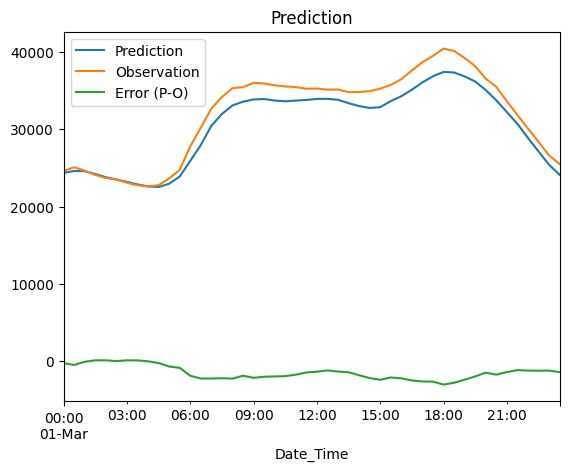

In [6]:
prediction = m.predict_from_model(model, observation_data, '2023-03-01', 48*1, dt.timedelta(minutes=30))
print(prediction.calculate_metrics())
prediction.plot()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10651 (41.61 KB)
Trainable params: 10651 (41.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


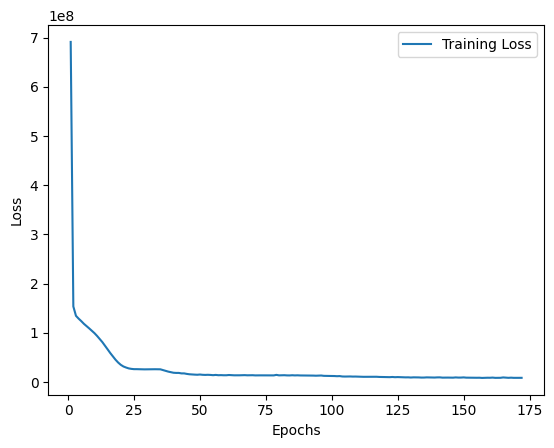

Trained Model (Lstm, {'AR_lags': [1, 2, 48], 'differences': 1, 'MA_lags': 0, 'normalise': False, 'Learning_rate': 0.05, 'Epochs': 300, 'Loss_function': 'mse', 'Plot_loss': True, 'variables': ['SETTLEMENT_PERIOD', 'Day_of_week']}) <keras.src.engine.sequential.Sequential object at 0x000001A8680F6F90>


In [7]:
model = m.create_model('Lstm', configuration)
m.train_model(model, observation_data, '2023-01-01', '2023-03-01')
print(model)

21/21 [==============================] - 0s 650us/step
{'MAE': 2092.788884943182, 'RMSE': 2544.35148638732, 'MAPE': 0.06804039487434993}


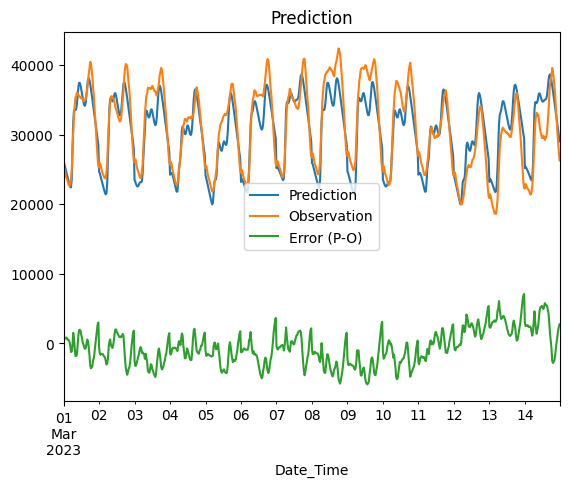

In [8]:
prediction = m.predict_from_model(model, observation_data, '2023-03-01', 48*14, dt.timedelta(minutes=30))
print(prediction.calculate_metrics())
prediction.plot()